# Supernova Recovery Integrated into `lightkurve`

In this notebook, I will create and show recovery of a supernova using `lightkurve`'s recovery method.

A lot of this code has already been written in the Example_SNrecovery_Poster in Jupyter Notebook in this directory.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's download a TPF of a galaxy and create the light curve.  I'm not going to normalize it, because knowing the background flux is important in the fitting process. I'm removing nans and outliers.

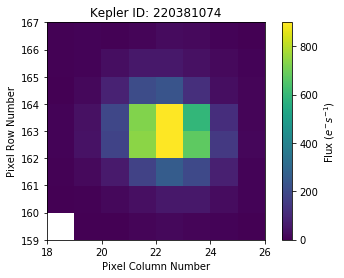

In [9]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

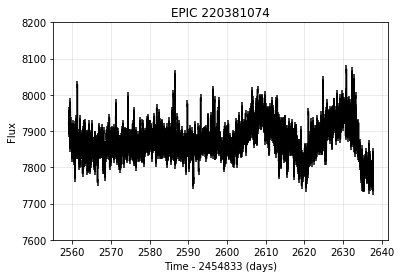

In [10]:
lc = tpf.to_lightcurve(aperture_mask='all') 

lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `lightkurve.injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2.e-7 [units?]

In [11]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()

Let's plot the model by itself:

Text(0,0.5,'Flux')

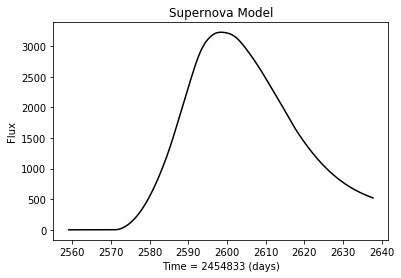

In [12]:
model_sn_eval = model.evaluate(lc.time)
plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

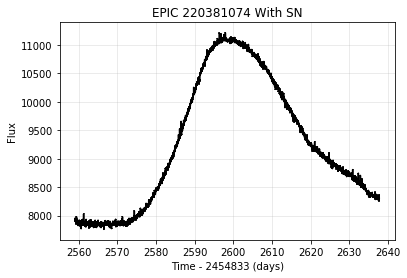

In [13]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

In [14]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [ ]:
%%time
result = inj.recover(lcinj, 'Supernova', x0)